## MNIST Digit Generator

Generating handwritten digits (0-9) similar to the digits in the MNISt dataset with a VAE model. This version of the VAE model uses fully-connected layers in the encoder- and decoder neural networks. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from models import VAE, VAELoss

In [2]:
# Load and store the MNIST train data 
transform = transforms.Compose([
    torchvision.transforms.ToTensor(), 
    torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=200, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


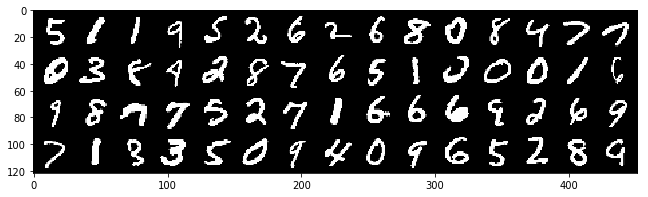

In [3]:
# Visualize some of the training data 
plt.figure(figsize=(15, 3))
digits, _ = next(iter(trainloader))
grid = torchvision.utils.make_grid(digits[0:60], nrow=15)
plt.imshow(grid.permute(1, 2, 0))
plt.show()

### Setting up and training the model 

We set up the VAE model, loss function, and optimizer and train the model with the training data. We flatten the dimension of the input images (?, 1, 28, 28) to a single dimension (?, 784) inside the model. 

In [4]:
# Setup model, criterion, and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

latent_size = 6 

# For model and loss function details see 'models.py' file. 
model = VAE(input_size=784, latent_size=latent_size).to(device)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr=4e-4)

In [5]:
# Training the model on the dataset
epochs = 100
for e in range(epochs):
    running_loss = 0
    for (_, data) in enumerate(trainloader, 0):
        x, _ = data
        x = x.to(device)

        optimizer.zero_grad()
        x, x_hat, mu, logvar, _ = model(x)
        loss = criterion(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    if e % 2 == 0:
        print(f"Epoch {e}: Loss {running_loss / len(trainloader)}")


Epoch 0: Loss 101122.71013020833
Epoch 2: Loss 64691.95040364583
Epoch 4: Loss 59817.52555989583
Epoch 6: Loss 57425.1259375
Epoch 8: Loss 55964.3658203125
Epoch 10: Loss 54885.70389322917
Epoch 12: Loss 54021.5462109375
Epoch 14: Loss 53280.144895833335
Epoch 16: Loss 52622.1471484375
Epoch 18: Loss 52037.89305989583
Epoch 20: Loss 51548.857018229166
Epoch 22: Loss 51087.40571614583
Epoch 24: Loss 50708.2829296875
Epoch 26: Loss 50378.62805989583
Epoch 28: Loss 50086.327447916665
Epoch 30: Loss 49811.142591145835
Epoch 32: Loss 49567.6152734375
Epoch 34: Loss 49343.9415625
Epoch 36: Loss 49148.313828125
Epoch 38: Loss 48956.01493489584
Epoch 40: Loss 48770.2768359375
Epoch 42: Loss 48612.86548177083
Epoch 44: Loss 48463.228359375
Epoch 46: Loss 48317.8209765625
Epoch 48: Loss 48180.658919270834
Epoch 50: Loss 48061.6278515625
Epoch 52: Loss 47949.3690625
Epoch 54: Loss 47827.7610546875
Epoch 56: Loss 47729.36567708333
Epoch 58: Loss 47631.81779947917
Epoch 60: Loss 47527.286328125
Epo

### Testing the trained model

We can create new samples by using the generator of the VAE. Inputs for the generator networks can be sampled as $z \sim \mathcal{N}(0, 1)$.

Generated images seem okay in some cases, but there is still room for improvement. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


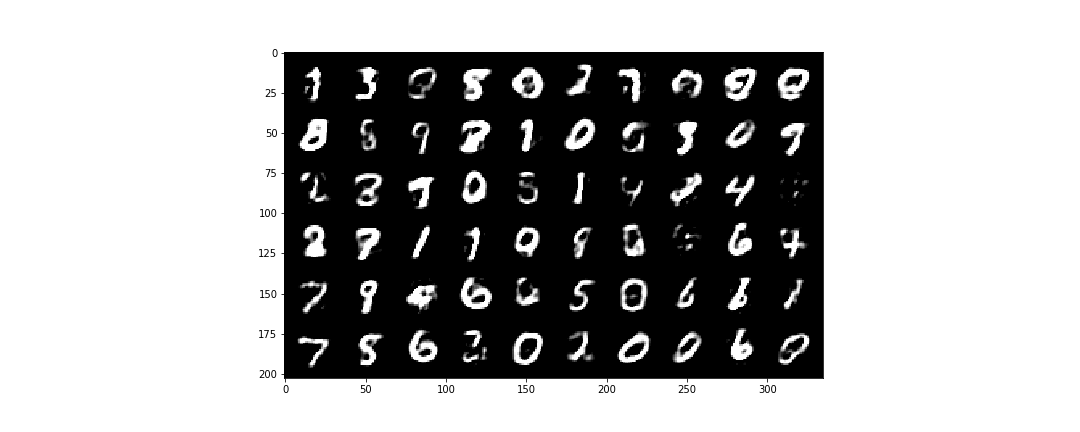

In [27]:
# setup z for decoder network input.
z_test = np.random.normal(size=(60, latent_size))
z_test = torch.from_numpy(z_test).float().to(device)

x_hat = model.decode(z_test)
# reshape into old image format 
x_hat = x_hat.view((-1, 1, 28, 28))

# create and visualize grid
grid = torchvision.utils.make_grid(x_hat, nrow=10, padding=5)
plt.figure(figsize=(15, 6))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.show()

### Analizing the latent space 

Visualizing the class distributions in the latent space (or rather the priniciple components thereof).

In [7]:
# get class y and latent representation z for 1000 samples
loader = torch.utils.data.DataLoader(trainset, batch_size=1000, shuffle=True)
x, y = next(iter(loader))
x = x.to(device)
_, _, _, _, z = model(x)

# convert to numpy for PCA
z = z.detach().cpu().numpy()
y = y.detach().cpu().numpy()

Visualizing the results in 2d. You can see that each class of digit is grouped in some form of blob in the scatter plot. However, the classes heavily overlap in some (edge)cases. 

In [20]:
# use PCA to reduce the dimensions of the latent dimension
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
pca.fit(z)

# reduce original z to lower dimensional x
print(f"Explained Variance: {np.sum(pca.explained_variance_ratio_):.2f}") 
x = pca.fit_transform(z)

Explained Variance: 0.44


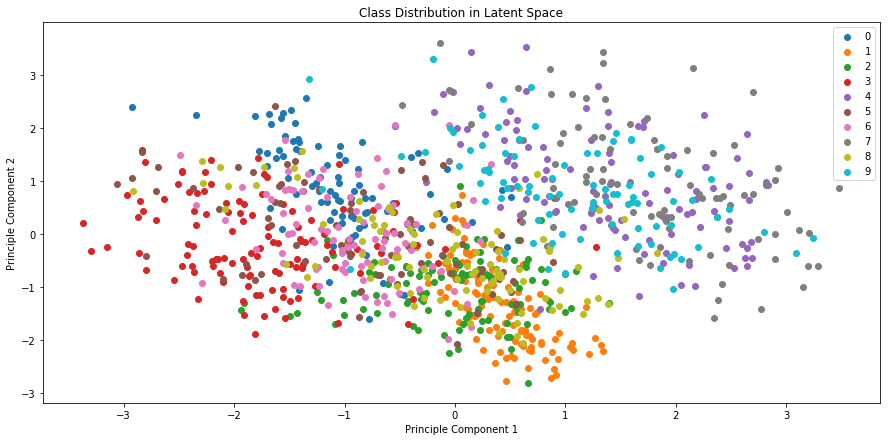

In [21]:
# plot the results in a scatter plot
scatter_x = x[:, 0]
scatter_y = x[:, 1]

plt.figure(figsize=(15, 7))

# split for 9 classes
for c in np.unique(y):
    idx = np.where(y == c)
    plt.scatter(scatter_x[idx], scatter_y[idx])
    
plt.legend([str(i) for i in range(0, 10)])
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.title('Class Distribution in Latent Space')
plt.show()

Visualizing the results in 3d. 

In [22]:
pca = decomposition.PCA(n_components=3)
pca.fit(z)

# reduce original z to lower dimensional x
print(f"Explained Variance: {np.sum(pca.explained_variance_ratio_):.2f}") 
x = pca.fit_transform(z)

Explained Variance: 0.61


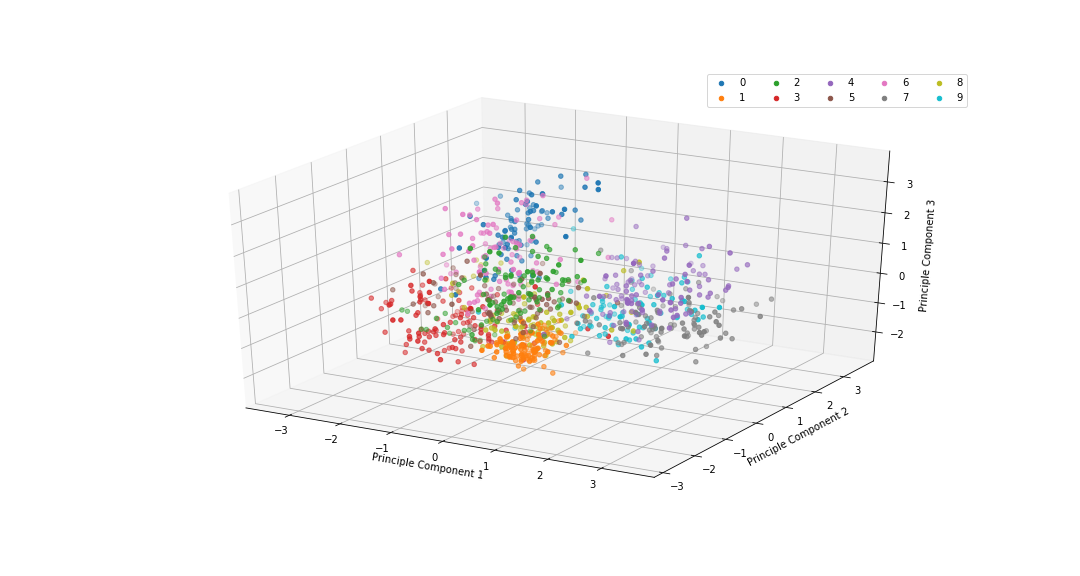

In [30]:
from mpl_toolkits.mplot3d import Axes3D

scatter_x = x[:, 0]
scatter_y = x[:, 1]
scatter_z = x[:, 2]

fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111, projection='3d')

# split for 9 classes
for c in np.unique(y):
    idx = np.where(y == c)
    ax.scatter(scatter_x[idx], scatter_y[idx], scatter_z[idx])

ax.set_xlabel('Principle Component 1')
ax.set_ylabel('Principle Component 2')
ax.set_zlabel('Principle Component 3')
ax.legend([str(i) for i in range(0, 10)], ncol=5)

plt.show()
